In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


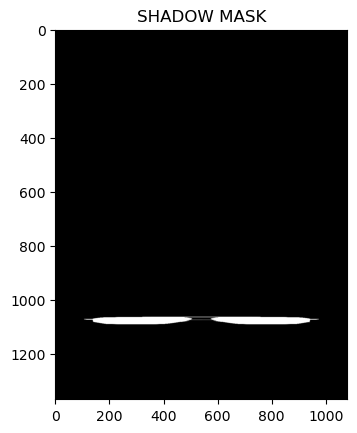

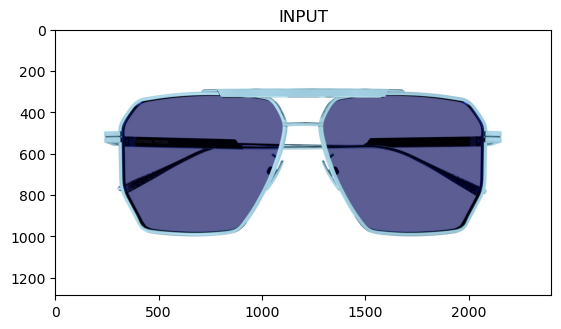

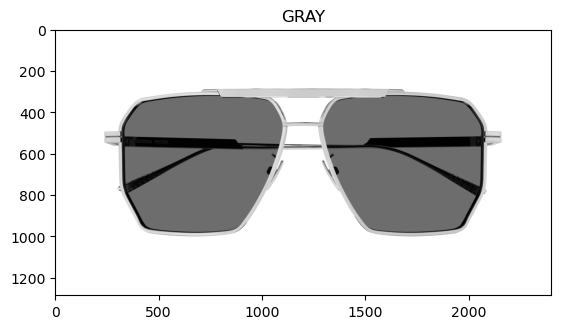

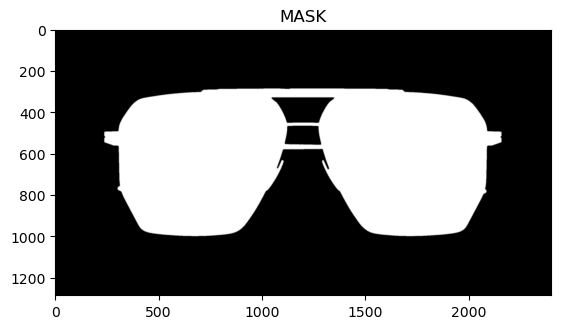

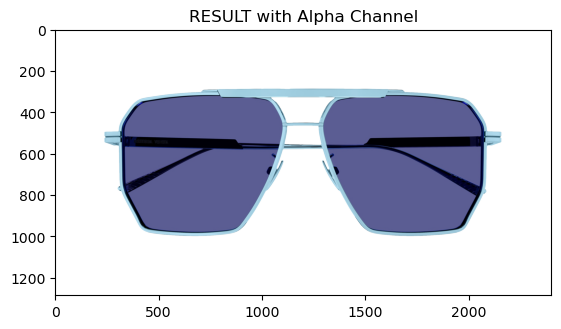

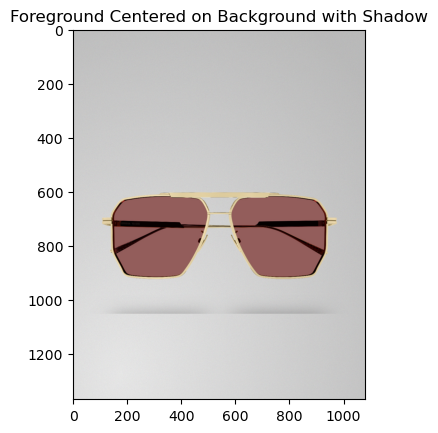

<Figure size 640x480 with 0 Axes>

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# load image
img = cv2.imread('image.jpg')

# convert to graky
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# Load the background image
bg_img = cv2.imread('bg.jpg')

# Get dimensions of the foreground and background images
fg_h, fg_w, _ = result.shape
bg_h, bg_w, _ = bg_img.shape

# Resize foreground image to match background width while maintaining aspect ratio
aspect_ratio = fg_w / fg_h
new_fg_w = bg_w
new_fg_h = int(new_fg_w / aspect_ratio)
result_resized = cv2.resize(result, (new_fg_w, new_fg_h))

# Update foreground dimensions after resizing
fg_h, fg_w, _ = result_resized.shape

# Calculate the position to center the foreground image
center_x = int((bg_w - fg_w) / 2)
center_y = int((bg_h - fg_h) / 2) + (int(bg_h /17))


# Ensure the foreground image fits within the background image
if center_x < 0 or center_y < 0 or center_x + fg_w > bg_w or center_y + fg_h > bg_h:
    print("Resized foreground image is still larger than the background image or centering is not possible.")
    # You might want to handle this case differently
else:
    # Create a region of interest in the background image for the foreground and shadow
    roi = bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w].copy()

    # Convert foreground and ROI to float32 for alpha blending
    fg_float = result_resized.astype(np.float32)
    roi_float = roi.astype(np.float32)

    # Extract alpha channel from foreground
    alpha = fg_float[:, :, 3] / 255.0
    alpha_3_channel = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR) # Convert alpha to 3 channels

    # Blend the foreground and ROI
    blended_fg = roi_float * (1 - alpha_3_channel) + fg_float[:,:,:3] * alpha_3_channel

    # --- Add shadow ---
    # Create a shadow mask from the resized foreground's alpha channel
    shadow_mask = result_resized[:,:,3]

    #resize the white area
    shadow_mask_resized = cv2.resize(shadow_mask, (fg_w, 50))

    # put the mask on top of a black image the size of the bg img
    shadow_mask = np.zeros((bg_h, bg_w), dtype=np.uint8)
    shadow_mask[center_y + fg_h:center_y + fg_h + 50, center_x:center_x + fg_w] = shadow_mask_resized

    plt.imshow(shadow_mask, cmap='gray')
    plt.title("SHADOW MASK")
    plt.figure()



    # Blur the shadow mask
    shadow_mask = cv2.GaussianBlur(shadow_mask, (0,0), sigmaX=30, sigmaY=30)

    shadow_alpha = shadow_mask.astype(np.float32) / 255.0
    shadow_alpha_3_channel = cv2.cvtColor(shadow_alpha, cv2.COLOR_GRAY2BGR)

    # Define shadow color and opacity
    shadow_color = (0, 0, 0) # Black shadow
    shadow_opacity = 0.6

    # Create a shadow layer with the same dimensions as the foreground ROI
    shadow_layer = np.full_like(roi, shadow_color, dtype=np.float32)

    # Blend the shadow with the blended foreground and background ROI
    # This blends the shadow onto the image area where the foreground will be placed
    shadow_and_fg_blended_roi = blended_fg * (1 - shadow_alpha_3_channel * shadow_opacity) + shadow_layer * shadow_alpha_3_channel * shadow_opacity


    # Place the final blended region (foreground and shadow) back into the background image
    bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w] = shadow_and_fg_blended_roi.astype(np.uint8)
    # --- End Add shadow ---


# display result, though it won't show transparency
plt.imshow(img)
plt.title("INPUT")
plt.figure()

plt.imshow(gray, cmap='gray')
plt.title("GRAY")
plt.figure()

plt.imshow(mask, cmap='gray')
plt.title("MASK")
plt.figure()

plt.imshow(result)
plt.title("RESULT with Alpha Channel")
plt.figure()

# Display the composite image
if center_x >= 0 and center_y >= 0 and center_x + fg_w <= bg_w and center_y + fg_h <= bg_h:
    plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
    plt.title("Foreground Centered on Background with Shadow")
    plt.figure()
    cv2.imwrite('output_image_with_shadow.webp', bg_img, [cv2.IMWRITE_WEBP_QUALITY, 70])
else:
    print("Resized foreground image is still larger than the background image or centering is not possible.")

plt.show()